In [1]:
import pandas as pd
from datetime import datetime, timezone, timedelta
import pytz
import seaborn as sns
import matplotlib.pyplot as plt

## Задача: 
1. Разработать  и  применить  алгоритм  вычисления  длительности  перелета  на  основе данных  о  покупках  билетов  и  любых  внешних  источников  данных,  которые предлагается  найти  самостоятельно. 
2. Построить  гистограмму  длительности  перелета  по  всем  данным. 
3. Найти  на  гистограмме  аномалии  (если  есть).


Входные  данные:  test_task_min.csv.  Данные  о  покупках  билетов  в  виде  таблицы,  где  строка соответствует  одному  билету.  Вам  известны  детали  билета,  такие  как  IATA-код  аэропорта вылета, IATA-код  аэропорта  прилета,  местные  дата  и  время  вылета,  местные  дата  и время  прилета, IATA-код  перевозчика.  Также  вам  понадобятся  дополнительные  данные, которые  предлагается  найти  самостоятельно. 

Выходные  данные: 

1. Исходная  таблица  с  добавленным  столбцом  длительности  перелета. 
2. Гистограмма  по  столбцу  длительности  перелета. 
3. Список  аномалий  (если  есть)  и  их  объяснение.

In [2]:
df = pd.read_csv('test_task_min.csv', sep=';')

Посмотрим на первые пять строк нашей исходной таблицы:

In [3]:
df.head()

,departure_code,arrival_code,date,arrival_date,carrier
0,YYZ,YVR,2019-10-30 10:30:00,2019-10-30 12:47:00,AC
1,SMF,LAX,2020-07-10 11:59:00,2020-07-10 13:27:00,OO
2,CLE,LAX,2019-03-25 18:20:00,2019-03-25 20:30:00,UA
3,BDL,ORD,2019-06-29 07:30:00,2019-06-29 09:03:00,UA
4,LAX,BOG,2018-11-16 19:10:00,2018-11-17 05:25:00,AV


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   departure_code  1000 non-null   object
 1   arrival_code    1000 non-null   object
 2   date            1000 non-null   object
 3   arrival_date    1000 non-null   object
 4   carrier         1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [5]:
df.duplicated().sum()

1

Удалим дубликаты:

In [6]:
df.drop_duplicates(inplace=True)

Приведем столбцы с датами к соответствующему типу:

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

Возьмем дополнительную таблицу с аэропортами

In [9]:
airports = pd.read_csv('https://query.data.world/s/diinfedngz2ebb3jxugjdxw6cxpqqv')

In [10]:
airports.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [11]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7698 entries, 0 to 7697
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Airport ID             7698 non-null   int64  
 1   Name                   7698 non-null   object 
 2   City                   7649 non-null   object 
 3   Country                7698 non-null   object 
 4   IATA                   7698 non-null   object 
 5   ICAO                   7698 non-null   object 
 6   Latitude               7698 non-null   float64
 7   Longitude              7698 non-null   float64
 8   Altitude               7698 non-null   int64  
 9   Timezone               7698 non-null   object 
 10  DST                    7698 non-null   object 
 11  Tz database time zone  7698 non-null   object 
 12  Type                   7698 non-null   object 
 13  Source                 7698 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 842.1+

In [12]:
df_airports = airports[['IATA','Tz database time zone']]

In [13]:
df_airports.head()

,IATA,Tz database time zone
0,GKA,Pacific/Port_Moresby
1,MAG,Pacific/Port_Moresby
2,HGU,Pacific/Port_Moresby
3,LAE,Pacific/Port_Moresby
4,POM,Pacific/Port_Moresby


Добавим к нашим данным временную зону, чтобы потом использовать ее для расчета времени по utc

In [15]:
df = df.merge(df_airports, how='left', left_on='departure_code', right_on='IATA') \
  .rename(columns={'Tz database time zone': 'departure_time_zone'}) \
  .drop(columns = ['IATA'],axis = 1) \
  .merge(df_airports, how='left', left_on='arrival_code', right_on='IATA') \
  .rename(columns={'Tz database time zone': 'arrival_time_zone'}) \
  .drop(columns = ['IATA'],axis = 1)

In [16]:
df.head()

,departure_code,arrival_code,date,arrival_date,carrier,departure_time_zone,arrival_time_zone
0,YYZ,YVR,2019-10-30 10:30:00,2019-10-30 12:47:00,AC,America/Toronto,America/Vancouver
1,SMF,LAX,2020-07-10 11:59:00,2020-07-10 13:27:00,OO,America/Los_Angeles,America/Los_Angeles
2,CLE,LAX,2019-03-25 18:20:00,2019-03-25 20:30:00,UA,America/New_York,America/Los_Angeles
3,BDL,ORD,2019-06-29 07:30:00,2019-06-29 09:03:00,UA,America/New_York,America/Chicago
4,LAX,BOG,2018-11-16 19:10:00,2018-11-17 05:25:00,AV,America/Los_Angeles,America/Bogota


In [18]:
df['departure_time_zone'].unique()

array(['America/Toronto', 'America/Los_Angeles', 'America/New_York',
       'America/Denver', 'America/Chicago', 'Europe/London',
       'Europe/Amsterdam', 'Asia/Tokyo', 'Europe/Lisbon',
       'America/Phoenix', 'Asia/Dubai', 'America/Mexico_City',
       'Asia/Kuwait', 'America/Puerto_Rico', 'America/Winnipeg',
       'America/Anchorage', 'Pacific/Honolulu', 'Europe/Copenhagen',
       'Europe/Zurich', 'Europe/Berlin', 'Europe/Tallinn',
       'America/Buenos_Aires', 'Asia/Taipei', 'Asia/Hong_Kong',
       'Europe/Stockholm', 'America/Sao_Paulo', 'Europe/Madrid',
       'America/Bogota', '\\N', 'Australia/Sydney', 'Europe/Paris',
       'America/Edmonton', 'America/Santiago', 'America/Port_of_Spain',
       'America/Cancun', 'Asia/Manila', 'America/Mazatlan',
       'America/Guatemala', 'Asia/Bahrain', 'America/Curacao',
       'Africa/Maputo', 'America/Vancouver', 'America/Panama',
       'Europe/Helsinki', 'Australia/Brisbane', 'Asia/Shanghai',
       'America/El_Salvador', 'Afric

В данных есть пропущенные значения, посмотрим на них внимательнее

In [19]:
df.query('departure_time_zone == r"\\N"')

,departure_code,arrival_code,date,arrival_date,carrier,departure_time_zone,arrival_time_zone
224,IST,MUC,2018-12-02 08:20:00,2018-12-02 09:10:00,UA,\N,Europe/Berlin
589,DOH,BKK,2018-04-02 20:35:00,2018-04-03 07:05:00,QR,\N,Asia/Bangkok
818,DOH,HYD,2019-06-18 19:10:00,2019-06-19 01:50:00,QR,\N,\N
852,DOH,CMB,2019-06-16 18:05:00,2019-06-17 01:45:00,QR,\N,Asia/Colombo
993,IST,IAD,2019-06-18 14:55:00,2019-07-18 19:30:00,TK,\N,America/New_York


In [20]:
df.query('arrival_time_zone == r"\\N"')

,departure_code,arrival_code,date,arrival_date,carrier,departure_time_zone,arrival_time_zone
36,KWI,DOH,2018-05-30 05:15:00,2018-05-30 06:40:00,QR,Asia/Kuwait,\N
304,JFK,DOH,2018-08-03 21:00:00,2018-08-04 16:25:00,QR,America/New_York,\N
578,JFK,DOH,2018-11-16 21:00:00,2018-11-17 17:40:00,QR,America/New_York,\N
696,JFK,DOH,2018-02-21 21:05:00,2018-02-22 17:35:00,QR,America/New_York,\N
818,DOH,HYD,2019-06-18 19:10:00,2019-06-19 01:50:00,QR,\N,\N


Необходимо заменить нулевые значения соответствующими

In [21]:
airports.query('IATA == "IST" | IATA == "DOH" | IATA == "HYD"')

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
6827,11051,Hamad International Airport,Doha,Qatar,DOH,OTHH,25.273056,51.608056,13,3,N,\N,airport,OurAirports
7298,12087,Rajiv Gandhi International Airport,Hyderabad,India,HYD,VOHS,17.231318,78.429855,2024,5.5,N,\N,airport,OurAirports
7629,13696,Istanbul Airport,Istanbul,Turkey,IST,LTFM,41.275278,28.751944,325,3,E,\N,airport,OurAirports


In [22]:
df.loc[(df.departure_code == 'IST'), 'departure_time_zone'] = 'Turkey'
df.loc[(df.departure_code == 'DOH'), 'departure_time_zone'] = 'Asia/Qatar'
df.loc[(df.departure_code == 'HYD'), 'departure_time_zone'] = 'Asia/Kolkata'

df.loc[(df.arrival_code == 'DOH'), 'arrival_time_zone'] = 'Asia/Qatar'
df.loc[(df.arrival_code == 'HYD'), 'arrival_time_zone'] = 'Asia/Kolkata'

In [23]:
df.head()

,departure_code,arrival_code,date,arrival_date,carrier,departure_time_zone,arrival_time_zone
0,YYZ,YVR,2019-10-30 10:30:00,2019-10-30 12:47:00,AC,America/Toronto,America/Vancouver
1,SMF,LAX,2020-07-10 11:59:00,2020-07-10 13:27:00,OO,America/Los_Angeles,America/Los_Angeles
2,CLE,LAX,2019-03-25 18:20:00,2019-03-25 20:30:00,UA,America/New_York,America/Los_Angeles
3,BDL,ORD,2019-06-29 07:30:00,2019-06-29 09:03:00,UA,America/New_York,America/Chicago
4,LAX,BOG,2018-11-16 19:10:00,2018-11-17 05:25:00,AV,America/Los_Angeles,America/Bogota


Переводим время к одному виду

In [24]:
def to_utc(d, time_zone):
  pst_tz = d.tz_localize(time_zone).tz_convert(None)
  return pst_tz

In [25]:
df['date_utc'] = df.apply(lambda x: to_utc(x['date'], x['departure_time_zone']), axis=1)
df['arrival_date_utc'] = df.apply(lambda x: to_utc(x['arrival_date'], x['arrival_time_zone']), axis=1)

Рассчитаем длительность перелета

In [26]:
df['delta'] = df['arrival_date_utc'] - df['date_utc']

In [27]:
df

,departure_code,arrival_code,date,arrival_date,carrier,departure_time_zone,arrival_time_zone,date_utc,arrival_date_utc,delta
0,YYZ,YVR,2019-10-30 10:30:00,2019-10-30 12:47:00,AC,America/Toronto,America/Vancouver,2019-10-30 14:30:00,2019-10-30 19:47:00,0 days 05:17:00
1,SMF,LAX,2020-07-10 11:59:00,2020-07-10 13:27:00,OO,America/Los_Angeles,America/Los_Angeles,2020-07-10 18:59:00,2020-07-10 20:27:00,0 days 01:28:00
2,CLE,LAX,2019-03-25 18:20:00,2019-03-25 20:30:00,UA,America/New_York,America/Los_Angeles,2019-03-25 22:20:00,2019-03-26 03:30:00,0 days 05:10:00
3,BDL,ORD,2019-06-29 07:30:00,2019-06-29 09:03:00,UA,America/New_York,America/Chicago,2019-06-29 11:30:00,2019-06-29 14:03:00,0 days 02:33:00
4,LAX,BOG,2018-11-16 19:10:00,2018-11-17 05:25:00,AV,America/Los_Angeles,America/Bogota,2018-11-17 03:10:00,2018-11-17 10:25:00,0 days 07:15:00
...,...,...,...,...,...,...,...,...,...,...
994,HKG,LAX,2018-09-06 00:05:00,2018-09-05 21:55:00,CX,Asia/Hong_Kong,America/Los_Angeles,2018-09-05 16:05:00,2018-09-06 04:55:00,0 days 12:50:00
995,JFK,LAX,2018-11-03 11:55:00,2018-11-05 14:57:00,DL,America/New_York,America/Los_Angeles,2018-11-03 15:55:00,2018-11-05 22:57:00,2 days 07:02:00
996,PVG,SFO,2018-11-25 00:15:00,2018-11-26 19:15:00,UA,Asia/Shanghai,America/Los_Angeles,2018-11-24 16:15:00,2018-11-27 03:15:00,2 days 11:00:00
997,EWR,KEF,2018-02-12 19:30:00,2018-03-12 06:00:00,FI,America/New_York,Atlantic/Reykjavik,2018-02-13 00:30:00,2018-03-12 06:00:00,27 days 05:30:00


Построим гистаграмму

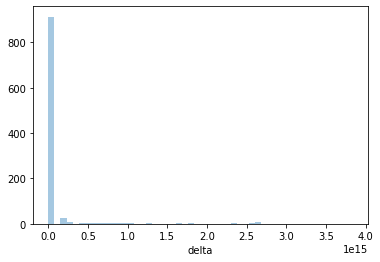

In [29]:
sns.distplot(df['delta'], kde = False)
plt.show()

In [30]:
df['delta'].describe()

count                          999
mean     1 days 04:30:53.448448448
std      4 days 15:57:37.819211089
min                0 days 00:30:00
25%                0 days 01:50:00
50%                0 days 03:01:00
75%                0 days 06:19:30
max               44 days 09:30:00
Name: delta, dtype: object

На гистограмме можно заметить выбросы и рассмотреть более точные значения с помощью функции describe. В 2021 году первое место среди беспосадочных регулярных коммерческих перелетов занимает вновь запущенный рейс Singapore Airlines из Нью-Йорка в сингапурский Чанги. Лететь 15348 км. Находиться в воздухе придется примерно 18 часов 40 минут. Исходя из этой информации, посмотрим на маршруты, которые привышают время полета в 18 часов.

In [31]:
df[df['delta'] > timedelta(days=0, hours=18, minutes=0, seconds=0)]

,departure_code,arrival_code,date,arrival_date,carrier,departure_time_zone,arrival_time_zone,date_utc,arrival_date_utc,delta
900,LAS,RDU,2019-05-02 23:20:00,2019-05-05 06:45:00,F9,America/Los_Angeles,America/New_York,2019-05-03 06:20:00,2019-05-05 10:45:00,2 days 04:25:00
901,ORD,KEF,2019-07-01 18:30:00,2019-08-01 06:35:00,FI,America/Chicago,Atlantic/Reykjavik,2019-07-01 23:30:00,2019-08-01 06:35:00,30 days 07:05:00
902,JFK,KEF,2018-02-10 20:20:00,2018-03-10 05:55:00,FI,America/New_York,Atlantic/Reykjavik,2018-02-11 01:20:00,2018-03-10 05:55:00,27 days 04:35:00
903,LGW,MCO,2018-06-11 11:45:00,2018-07-25 16:15:00,VS,Europe/London,America/New_York,2018-06-11 10:45:00,2018-07-25 20:15:00,44 days 09:30:00
904,SJD,LAX,2019-03-23 12:45:00,2019-03-28 15:27:00,DL,America/Mazatlan,America/Los_Angeles,2019-03-23 19:45:00,2019-03-28 22:27:00,5 days 02:42:00
...,...,...,...,...,...,...,...,...,...,...
992,BRU,EWR,2018-06-30 10:00:00,2018-07-02 12:10:00,UA,Europe/Brussels,America/New_York,2018-06-30 08:00:00,2018-07-02 16:10:00,2 days 08:10:00
993,IST,IAD,2019-06-18 14:55:00,2019-07-18 19:30:00,TK,Turkey,America/New_York,2019-06-18 11:55:00,2019-07-18 23:30:00,30 days 11:35:00
995,JFK,LAX,2018-11-03 11:55:00,2018-11-05 14:57:00,DL,America/New_York,America/Los_Angeles,2018-11-03 15:55:00,2018-11-05 22:57:00,2 days 07:02:00
996,PVG,SFO,2018-11-25 00:15:00,2018-11-26 19:15:00,UA,Asia/Shanghai,America/Los_Angeles,2018-11-24 16:15:00,2018-11-27 03:15:00,2 days 11:00:00


Итак мы имеем 86 маршрутов, которые длятся более 18 часов. Возьмем самый длительный полет и посмотрим между какими городами он был совершен.

In [32]:
airports_city = airports[['City', 'IATA']]

In [34]:
df[df['delta'] == df['delta'].max()].merge(airports_city, how='left', left_on='departure_code', right_on='IATA') \
  .rename(columns={'City': 'departure_city'}) \
  .drop(columns=['IATA'], axis=1) \
  .merge(airports_city, how='left', left_on='arrival_code', right_on='IATA') \
  .rename(columns={'City': 'arrival_city'}) \
  .drop(columns=['IATA'], axis=1)

,departure_code,arrival_code,date,arrival_date,carrier,departure_time_zone,arrival_time_zone,date_utc,arrival_date_utc,delta,departure_city,arrival_city
0,LGW,MCO,2018-06-11 11:45:00,2018-07-25 16:15:00,VS,Europe/London,America/New_York,2018-06-11 10:45:00,2018-07-25 20:15:00,44 days 09:30:00,London,Orlando


Маршрут Лондон-Орландо без пересадок длится 9 часов 20 минут. Я думаю, что либо в данных произошел сбой, либо эти маршруты указаны с пересадками, поэтому такое большое время полета.